In [1]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from fgsm.deep_convnet import DeepConvNet
%matplotlib inline

from common.functions import softmax

Using TensorFlow backend.


In [2]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# # 1次元へ整形
# x_train, x_test = x_train.reshape(-1, 784), x_test.reshape(-1, 784)

##  4次元へ整形
x_train_shape = x_train.shape
x_train = x_train.reshape(x_train_shape[0], 1, x_train_shape[1], x_train_shape[2])

x_test_shape = x_test.shape
x_test = x_test.reshape(x_test_shape[0], 1, x_test_shape[1], x_test_shape[2])


# 正規化
x_train, x_test = x_train.astype(np.float32) / 255.0, x_test.astype(np.float32) / 255.0

In [3]:
network = DeepConvNet()

network.load_params("../fgsm/deep_convnet_params.pkl")
print("loaded Network Parameters!")

loaded Network Parameters!


In [4]:
test_acc = network.accuracy(x_test, t_test)
print("モデルAの正答率：", test_acc)

モデルAの正答率： 0.9925


In [5]:
def generate_adv(x, label, network, eps=0.01):
    d, g = network.gradient_for_fgsm(x.reshape(1, 1, 28, 28), np.array([label]))
    d = d.reshape(28, 28)
    p = eps * np.sign(d)
    adv = (x + p).clip(min=0, max=1)
    adv = adv.reshape(1, 1, 28, 28)
    return adv

In [6]:
def change_adv_list(x_list, t_list, network, eps):
    adv_list = []
    for x, t in zip(x_list, t_list):
        adv = generate_adv(x, t, network, eps)
        adv_list.append(adv.reshape(1, 28, 28))
        
    adv_list = np.array(adv_list)
    return adv_list

In [7]:
fgsm_test = change_adv_list(x_test, t_test, network, 0.3)
fgsm_test.shape

(10000, 1, 28, 28)

In [8]:
fgsm_acc = network.accuracy(fgsm_test, t_test)

In [9]:
print("FGSMに対するモデルAの正答率：", fgsm_acc)

FGSMに対するモデルAの正答率： 0.3682


In [10]:
import keras
from keras.models import model_from_json
from keras.utils import np_utils
from keras.optimizers import RMSprop

In [11]:
num_classes = 10

X_train = x_train.reshape(60000, 784)
X_test  = x_test.reshape(10000, 784)

y_train = keras.utils.to_categorical(t_train, num_classes)
y_test = keras.utils.to_categorical(t_test, num_classes)

In [12]:
# モデルを読み込む
model = model_from_json(open('../keras_sample/mnist_mlp_model.json').read())

# 学習結果を読み込む
model.load_weights('../keras_sample/mnist_mlp_weights.h5')

model.summary();

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

W1126 18:05:32.228135 140736894542784 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1126 18:05:32.269851 140736894542784 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1126 18:05:32.295780 140736894542784 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1126 18:05:32.296741 140736894542784 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placehol

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [13]:
score = model.evaluate(X_test, y_test, verbose=0)
# print('Test loss :', score[0])
print('モデルBの正答率：', score[1])

モデルBの正答率： 0.9842


In [14]:
FGSM_test = fgsm_test.reshape(x_test.shape[0], 784)
fgsm_score = model.evaluate(FGSM_test, y_test, verbose=0)
# print('Test loss :', score[0])
print('FGSMに対するモデルBの正答率：', fgsm_score[1])

FGSMに対するモデルBの正答率： 0.5309


In [15]:
FGSM_test[0].shape

(784,)

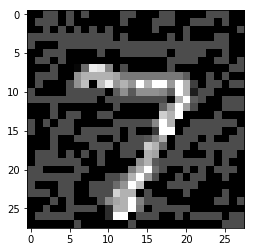

In [16]:
plt.imshow(FGSM_test[0].reshape(28,28), 'gray')
plt.show()